# Analaysis of filter type and their effect on readout

Modified from casper's PFB Introduction book. See [This repsitory](https://github.com/telegraphic/pfb_introduction/tree/master)

In [1]:

# Import required modules
import numpy as np
import scipy
from scipy.signal import firwin, freqz, lfilter
import matplotlib.pyplot as plt

def db(x):
    """ Convert linear value to dB value """
    return 10*np.log10(x)

In [ ]:
def pfb_fir_frontend(x, win_coeffs, M, P):
    W = int(x.shape[0] / M / P)
    x_p = x.reshape((W*M, P)).T
    h_p = win_coeffs.reshape((M, P)).T
    x_summed = np.zeros((P, M * W - M))
    for t in range(0, M*W-M):
        x_weighted = x_p[:, t:t+M] * h_p
        x_summed[:, t] = x_weighted.sum(axis=1)
    return x_summed.T

In [3]:
def generate_win_coeffs(M, P, window_fn="hamming"):
    win_coeffs = scipy.signal.get_window(window_fn, M*P)
    sinc       = scipy.signal.firwin(M * P, cutoff=1.0/P, window="rectangular")
    win_coeffs *= sinc
    return win_coeffs


In [4]:
# CONSTANTS
M     = 4          # Number of taps
P     = 1024       # Number of 'branches', also fft length
W     = 1000       # Number of windows of length M*P in input time stream
n_int = 2          # Number of time integrations on output data
WIN_SINC = scipy.signal.firwin(M * P, cutoff=1.0/P, window="rectangular")
WIN_HAMMING = generate_win_coeffs(M, P, "hamming")
WIN_BOXCAR = generate_win_coeffs(M, P, "boxcar")
WIN_TRIANG = generate_win_coeffs(M, P, "triang")
WIN_BLACKMAN = generate_win_coeffs(M, P, "blackman")
WIN_HANN = generate_win_coeffs(M, P, "hann")
WIN_BARTLETT = generate_win_coeffs(M, P, "bartlett")
WIN_FLATTOP = generate_win_coeffs(M, P, "flattop")
WIN_PARZEN = generate_win_coeffs(M, P, "parzen")
WIN_BOHMAN = generate_win_coeffs(M, P, "bohman")
WIN_BLACKMANHARRIS = generate_win_coeffs(M, P, "blackmanharris")
WIN_NUTTALL = generate_win_coeffs(M, P, "nuttall")
WIN_BARTHANN = generate_win_coeffs(M, P, "barthann")
WIN_COSINE = generate_win_coeffs(M, P, "cosine")
WIN_EXPONENTIAL = generate_win_coeffs(M, P, "exponential")
WIN_TUKEY = generate_win_coeffs(M, P, "tukey")
WIN_TAYLOR = generate_win_coeffs(M, P, "taylor")
WIN_LANCZOS = generate_win_coeffs(M, P, "lanczos")


windowList = [WIN_SINC,WIN_HAMMING,WIN_BOXCAR,WIN_TRIANG,WIN_BLACKMAN,WIN_HANN,WIN_BARTLETT,
              WIN_FLATTOP,WIN_PARZEN,WIN_BOHMAN,WIN_BLACKMANHARRIS,WIN_NUTTALL,WIN_BARTHANN,
              WIN_COSINE,WIN_EXPONENTIAL,WIN_TUKEY,WIN_TAYLOR, WIN_LANCZOS
            ]
names = [
"SINC","HAMMING","BOXCAR","TRIANG","BLACKMAN","HANN","BARTLETT","FLATTOP","PARZEN","BOHMAN",
"BLACKMANHARRIS","NUTTALL","BARTHANN","COSINE","EXPONENTIAL","TUKEY","TAYLOR","LANCZOS"]

In [5]:
def fft(x_p, P, axis=1):
    return np.fft.rfft(x_p, P, axis=axis)

def pfb_spectrometer(x, n_taps, n_chan, n_int, win_coeffs):
    M = n_taps
    P = n_chan
    
    # Apply frontend, take FFT, then take power (i.e. square)
    x_fir = pfb_fir_frontend(x, win_coeffs, M, P)
    x_pfb = fft(x_fir, P)
    x_psd = np.abs(x_pfb)**2
    
    # Trim array so we can do time integration
    x_psd = x_psd[:np.round(x_psd.shape[0]//n_int)*n_int]
    
    # Integrate over time, by reshaping and summing over axis (efficient)
    x_psd = x_psd.reshape(x_psd.shape[0]//n_int, n_int, x_psd.shape[1])
    x_psd = x_psd.mean(axis=1)
    
    return x_psd



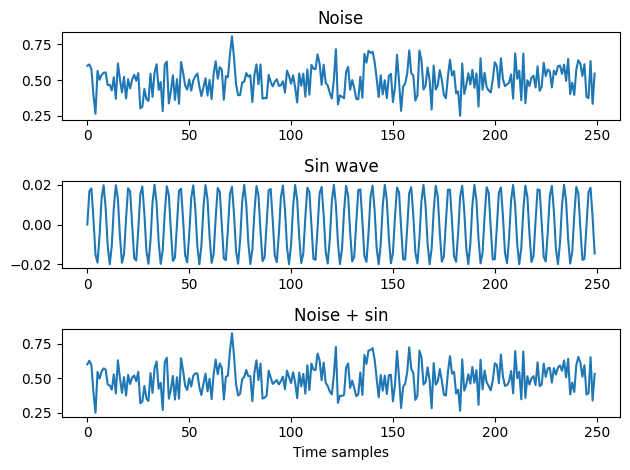

In [6]:
# Generate a test data steam
samples = np.arange(M*P*W)
noise   = np.random.normal(loc=0.5, scale=0.1, size=M*P*W) 
freq = 1
amp  = 0.02
cw_signal = amp * np.sin(samples * freq)
data = noise + cw_signal

plt.subplot(3,1,1)
plt.title("Noise")
plt.plot(noise[:250])
plt.subplot(3,1,2)
plt.title("Sin wave")
plt.plot(cw_signal[:250])
plt.subplot(3,1,3)
plt.title("Noise + sin")
plt.plot(data[:250])
plt.xlabel("Time samples")
plt.tight_layout()
plt.show()

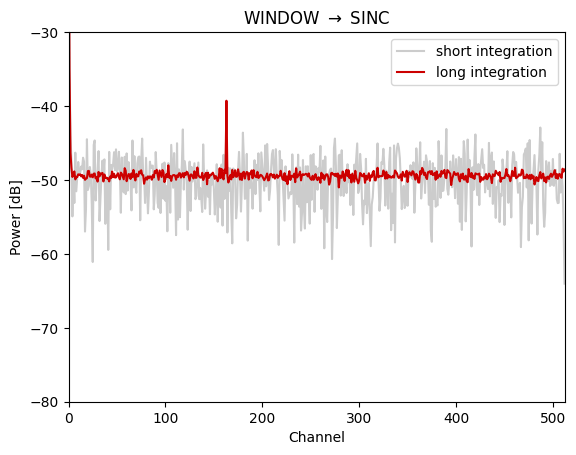

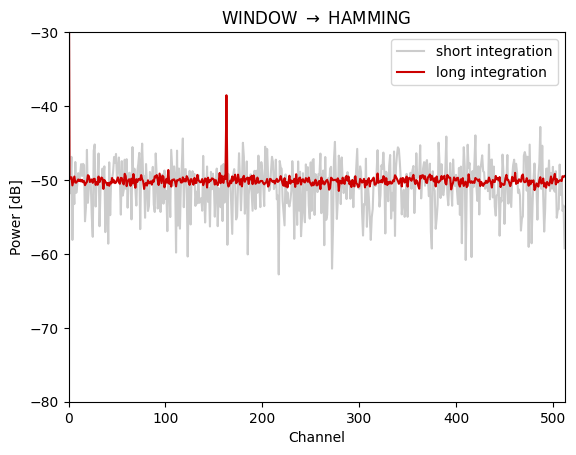

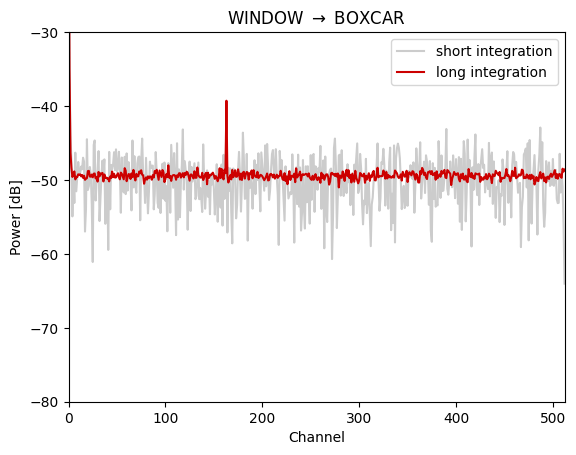

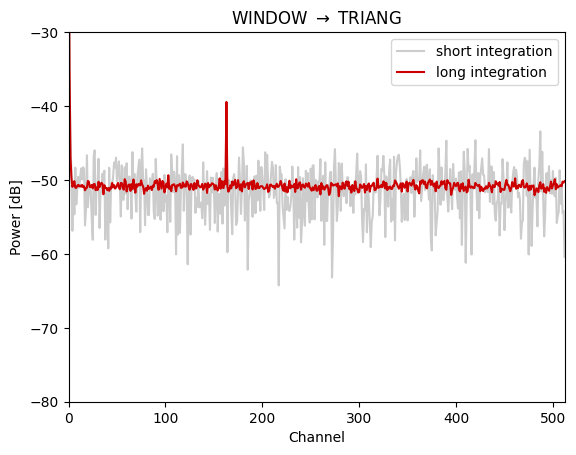

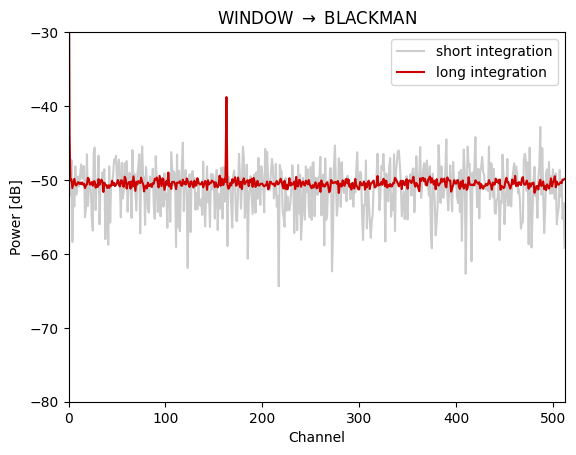

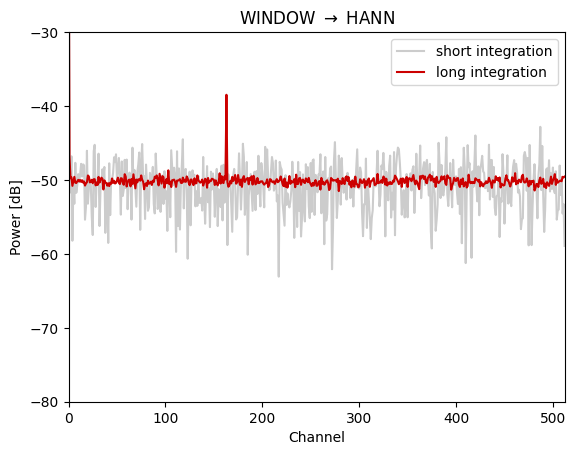

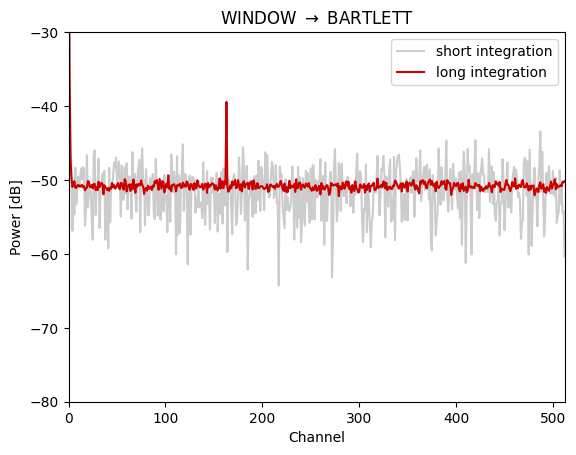

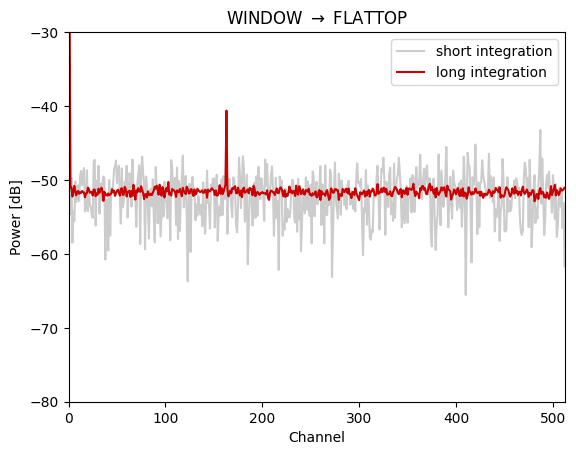

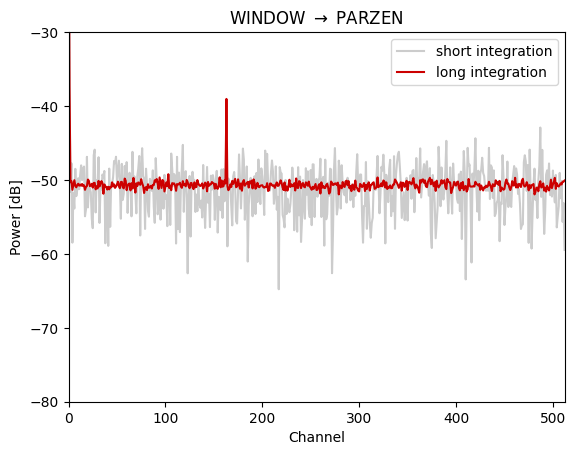

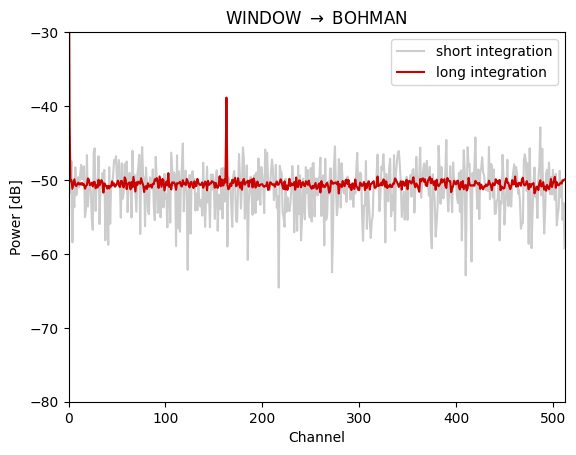

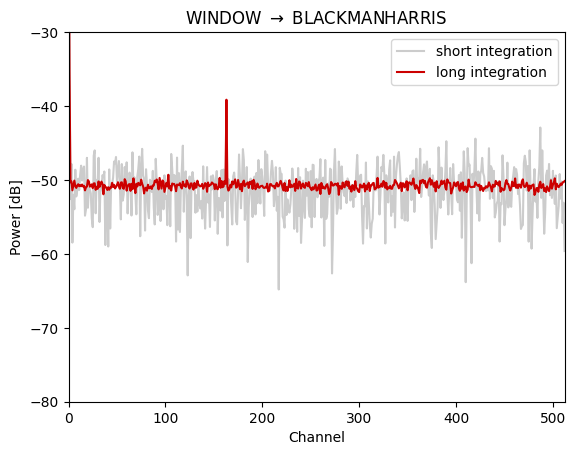

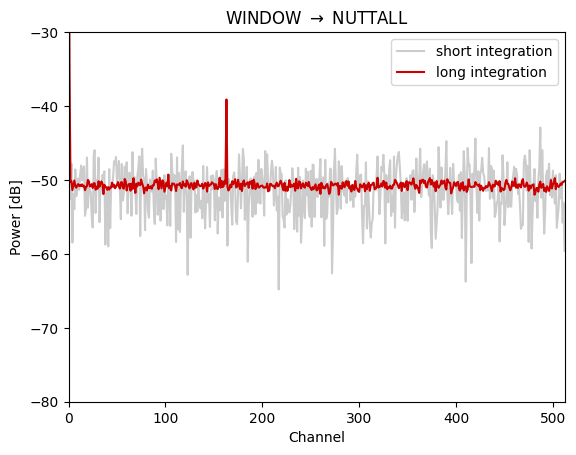

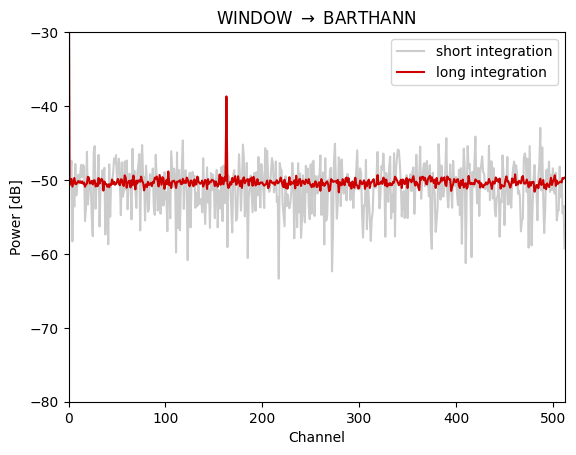

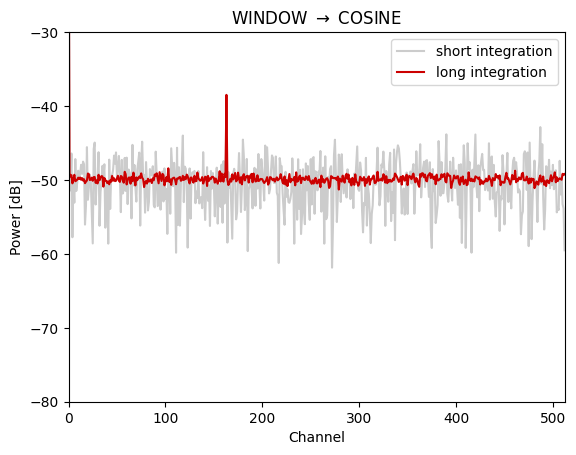

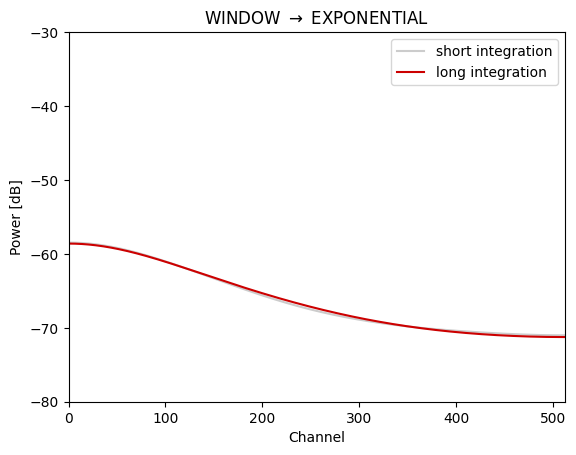

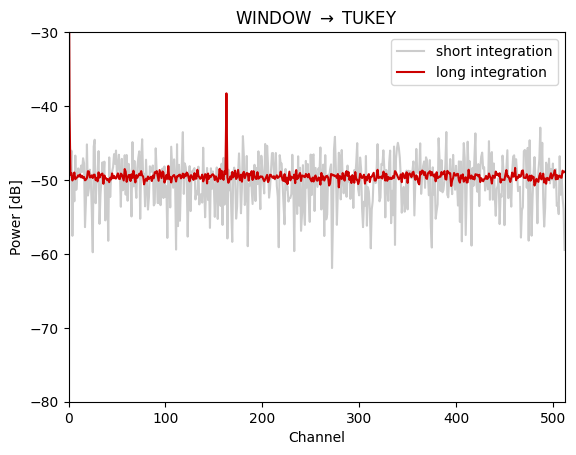

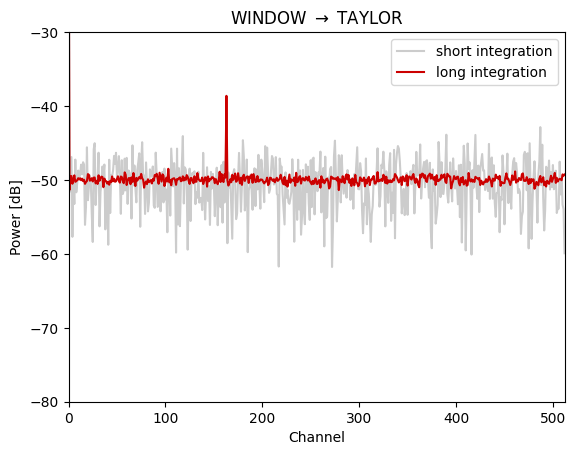

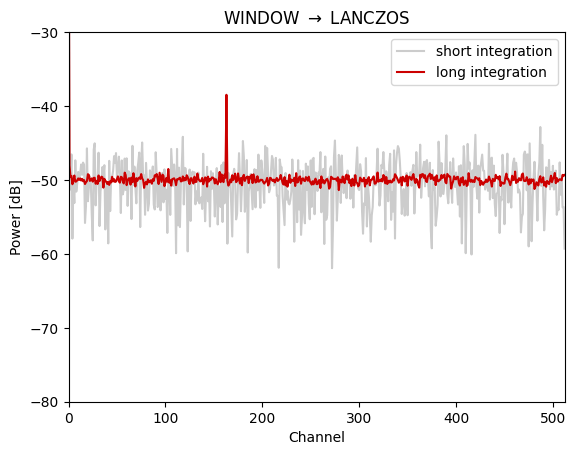

In [12]:
for indx, win in enumerate(windowList):
    X_psd = pfb_spectrometer(data, n_taps=M, n_chan=P, n_int=2, win_coeffs=win)
    X_psd2 = pfb_spectrometer(data, n_taps=M, n_chan=P, n_int=100, win_coeffs=win)

    plt.plot(db(X_psd[0]), c='#cccccc', label='short integration')
    plt.plot(db(X_psd2[1]), c='#cc0000', label='long integration')
    plt.ylim(-80, -30)
    plt.xlim(0, P/2)
    plt.xlabel("Channel")
    plt.title(f"WINDOW $\\rightarrow$ {names[indx]}")
    plt.ylabel("Power [dB]")
    plt.legend()
    plt.show()

In [ ]:
# Noise
def noise_plot(I,Q,npoints):
    # initialize variables
    nfs = int(np.log2(npoints))
    f_interp = np.zeros(nfs)
    Spp_i_interp = np.zeros((1024,nfs))
    Spp_q_interp = np.zeros((1024,nfs))
    Spp_interp = np.zeros((1024,nfs))

    # find the power in each detector
    rms_per_det = np.std(I,axis=1) + np.std(Q,axis=1)
    # find the detector with median power
    idet_median = np.argsort(rms_per_det)[int(len(rms_per_det)/2)]
    
    #for idet in range(4,14):
    for idet in range(len(I[:,0])):
        # form the complex signal of this detector
        Z = I[idet,:] + 1j*Q[idet,:]

        # calculate the DC value for this detector
        norm = np.mean(np.abs(Z))

        # take the Welch periodogram (viewer-friendly FFT)
        # of the real and imaginary parts of the signal
        f,Spp_i=scipy.signal.welch(np.real(Z)/norm,fs=512e6/2**(10+8),nperseg=npoints)
        f,Spp_q=scipy.signal.welch(np.imag(Z)/norm,fs=512e6/2**(10+8),nperseg=npoints)

        # smooth the curve further for plotting
        for j in range(0,nfs-1):
            f_interp[j] = np.mean(f[2**j:2**(j+1)])
            Spp_i_interp[idet,j] = np.mean(Spp_i[2**j:2**(j+1)])
            Spp_q_interp[idet,j] = np.mean(Spp_q[2**j:2**(j+1)])

        # combine I and Q spectra for plotting
        Spp_interp[idet,:] = (Spp_i_interp[idet,:] + Spp_q_interp[idet,:])/2

        # plot non smoothed data
        plt.semilogx(f[:],10*np.log10(Spp_i[:])[:],"-",color="blue",alpha=0.5)#,label="All Detectors")
        plt.semilogx(f[:],10*np.log10(Spp_q[:])[:],"-",color="orange",alpha=0.5)#,label="All Detectors")

        # if we are at the detector with median power
        if idet == idet_median:
            # plot this again, but with a solid black line to highlight it
            plt.semilogx(f_interp[:],10*np.log10(Spp_interp[idet,:])[:],"-",color="black",alpha=1.00,label="Median Detectors")
    
    # fname = 'OUT/'+file.split('/')[1].split('.')[0]

    #fname = filename
    # plt.figure(figsize=(12,8))
    plt.title("" + fname)# 20-900 Channel 2")
    plt.ylabel(r"$S_{\phi \phi}$ [dBc/Hz]", fontsize=16); 
    plt.xlabel("Hz", fontsize=16)
    plt.ylim(-150,-10)
    #plt.yticks(np.linspace(-110, -50, abs(110-50)-1))
    plt.grid()
    plt.savefig(fname)
    plt.show()
    print(filename)
    return
    